# **Large language models for (psycho)linguistics**

---

---

---

### Marco Ciapparelli, University of Milano-Bicocca
For any iquiry or feedback, please reach out! [[website](https://marcociapparelli.github.io/), [mail](marco.ciapparelli@unimib.it)]


<br>

---

### **Topics**
The present notebook is a guide on (mostly) language models. It was developed over the course of two workshops as a learning resource for psychologists, linguists and neuroscientists, and is geared toward that audience (I'm one of them myself 😺). Lacking extensive commentary, I suggest using the notebook as a playground! Code sections also come with example exercises, followed by possible solutions. The main topics covered are:
*   **representations** in LLMs: extracting and comparing word embeddings, probe the effects of context, compare representations within and across models
*   **prediction** in LLMs: extracting predictability measures, use them to probe the 'knowledge' of models
*   **multimodality**: extract representations from a computer vision models, compare them to those of LLMs, and extract prediction measures from language-vision models

<br>

---

---

### **Acknowledgements**

The notebook was first developed for [WoProc 2024](https://moproc2024.net/) (2h workshop) and was then greatly expanded for the [MEDAL Summer School in Computational Modelling](https://medal.ut.ee/event/medal-summer-school-in-computational-linguistics/) (6h workshop). I am grateful to the organizers of WoProc and MEDAL for the opportunity to carry out my workshops and thus develop these materials, and to the attendees for their feedback. I am thankful to Marco Marelli, Anastasia Galkina and Lance Gamboa for their comments, to Giovanni Cassani and Fritz Günther for sharing valuable materials. Finally, most of what is covered leverages (and is made possible by) the `minicons` library:
<medium>
> Misra, K. (2022). minicons: Enabling flexible behavioral and representational analyses of transformer language models. arXiv preprint arXiv:2203.13112.
</medium>

<br>

# **Importing**


---


import libraries, models, and data

In [ ]:
# install minicons (restart runtime)
!pip install minicons

In [ ]:
# import libraries

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import minicons

<br>

# **1. Representations (CWE module)**

---

---

---

<br>

In [ ]:
# @title ###### **(re-load and re-define functionalities** -- if runtime error)

# this cell can be used to import libraries, define functions and load models at
# once in case the runtime is disconnected (e.g., when switching between CPU and
# GPU)

# import -----------------------------------------------------------------------

!pip install minicons

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import minicons
from minicons import cwe
from minicons import scorer

# define similarity funtions ---------------------------------------------------

def sim_pair(tensor_a,tensor_b):
  norm_a = tensor_a.norm(p = 2)
  norm_b = tensor_b.norm(p = 2)
  dot_prod = torch.dot(tensor_a, tensor_b)
  cosine = dot_prod / (norm_a * norm_b) # use formula
  return cosine

def sim(tensors):
  cosine_similarities = torch.zeros((len(tensors), len(tensors)))
  for i in range(len(tensors)):
    for j in range(len(tensors)):
      cosine_similarities[i,j] = sim_pair(tensors[i,], tensors[j,])
  return cosine_similarities

def rsa(rsm1,rsm2):

  if (rsm1.shape == rsm2.shape):
    upper_indices = torch.triu_indices(rsm1.shape[0], rsm1.shape[1], offset = 1)
    rsm1 = rsm1[upper_indices[0], upper_indices[1]]
    rsm2 = rsm2[upper_indices[0], upper_indices[1]]

    r = torch.corrcoef(torch.stack([rsm1, rsm2]))
    r = r[0,1]
    return r
  else:
    print('RDMs dimensions do not match')

# import models ----------------------------------------------------------------

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_bert = cwe.CWE('google-bert/bert-base-uncased', device = my_device)

In [ ]:
# import module

from minicons import cwe


<br>

### **1.1. CWE: embeddings and similarity**


---

sequences of text (e.g., words, phrases) are represented by high-dimensional **embeddings** in a semantic space where proximity is directly proportional to **semantic similarity**. We can estimate the semantic similarity of two e.g., words by computing a measure of proximity of their embeddings (usually, by computing their cosine similarity). Generally, LLMs' embeddings are modulated by context, i.e., the representation of a word will be altered by the sentential context in which it is found.

---

Let's now extract *Contextualized* Word Embeddings (CWE) from a language model and compute their cosine similarity.

In [ ]:
# import language model

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # GPU or else CPU
model_bert = cwe.CWE('google-bert/bert-base-uncased', device = my_device) # from https://huggingface.co/models

In [ ]:
# extract contextualized word embeddings

sentences_example = [['the fields are yellow and green, the sky is blue','green'],
 ['the fields are yellow and green, the sky is blue','yellow'],
 ['the fields are yellow and green, the sky is blue','blue']]

# get embeddings (input to extract_representation is ['sequence','subsequence of interest'])
v = model_bert.extract_representation(sentences_example)


<br>

In PyTorch, embeddings are represented by **tensors**. Tensors are a generalization of vectors and matrices to *n*-dimensional arrays. The emebeddings exctracted by a language model will be represented as (1D) tensors

<center>
  <img src="https://drive.google.com/uc?export=view&id=1ycGNPLdLw7sIkCQiZJXL9O_ew1ue8AqS" width="600"/>
</center>

---

creating tensors:
```
scalar = torch.tensor(1) # scalar.ndim = 0
vector = torch.tensor([2,1]) # vector.ndim = 1
matrix = torch.tensor([[1,1],[2,3]]) # matrix.ndim = 2
tensor = torch.tensor([[[1,1],[2,2]],[[3,3],[4,4]]]) #tensor.ndim = 3
random_tensor = torch.rand(1,2,3) # (depth, height (rows), width (cols))
```
manipulating tensors:
```
t = torch.tensor([[[1,2,3],[4,5,6]]]) # based on (3,1,2) tensor
t[0,:,1] # get content at depth zero, for all rows and for the second column
t.reshape([6,1,1]) # reshapes by specifying the number of elements along each dimensions
t.permute([2,0,1]) # reshapes by swapping dimensions (here, dim 2 to 0, 1 to 2, and 0 to 1)
t.squeeze() # remove all dimensions of size 1
t.unsqueeze(0) # add dimensions of size 1 to the position in the argument
torch.transpose(t,0,1) # transpose (swap dimension 0 and 1)
torch.cat([t,t],2) # concatenate tensors along specified dimenion (here, dim = 2)
```




To quantify the similarity of two embeddings, we can compute their **cosine similairity**. The cosine similarity between the **a** and **b** embeddings (tensors) is computed as:

<br>

\begin{equation}
\cos ({\bf a},{\bf b})= {{\bf a} {\bf b} \over \|{\bf a}\| \|{\bf b}\|} = \frac{ \sum_{i=1}^{n}{{\bf a}_i{\bf b}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf a}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf b}_i)^2}} }
\end{equation}

Where:
\begin{equation}
\cos ({\bf a},{\bf b}) \in [-1,+1]
\end{equation}

<center>
  <img src="https://drive.google.com/uc?export=view&id=1TvIEDY8h2zcP6M3WyBk-bSxUqieVu8LU" width="250"/>
</center>

In [ ]:
# define (succint) cosine similarity functions

# get cosine similarity between tensor pairs
def sim_pair(tensor_a,tensor_b):

  norm_a = tensor_a.norm(p = 2)
  norm_b = tensor_b.norm(p = 2)
  dot_prod = torch.dot(tensor_a, tensor_b)
  cosine = dot_prod / (norm_a * norm_b) # use formula
  return cosine

# get a matrix of cosine similarities among an arbitrary number of tensors
def sim(tensors):

  cosine_similarities = torch.zeros((len(tensors), len(tensors)))
  for i in range(len(tensors)):
    for j in range(len(tensors)):
      cosine_similarities[i,j] = sim_pair(tensors[i,], tensors[j,]) # re-use the sim_pair() function
  return cosine_similarities


In [ ]:
# compute similarity of example sentences

res = [] # with sim_pair()
res.append(sim_pair(v[0,], v[1,])) # similarity between word 1 and 2
res.append(sim_pair(v[0,], v[2,])) # similarity between word 1 and 3
res.append(sim_pair(v[1,], v[2,])) # similarity between word 2 and 3
print(res)

res = sim(v) # with sim() -- all pairwise similarities
print(res)

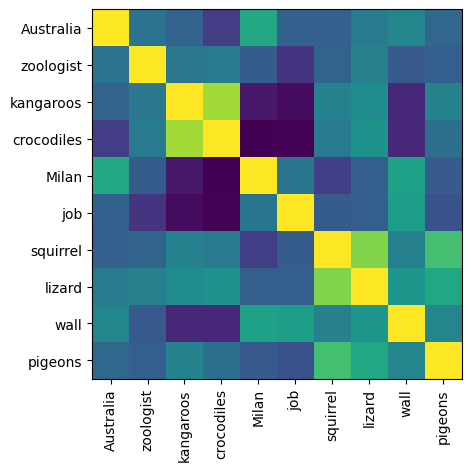

In [ ]:
# example to test 'intuitive' similarities among concepts in a sentence

sentence = 'As a zoologist, Australia is a good opportunity for me to study animals '\
'such as crocodiles and kangaroos. In Milan my job is so much harder, as I\'m lucky if '\
'I ever see a tiny squirrel or a lizard on a wall. There are plenty of pigeons though.'
target_items = ['Australia','zoologist','kangaroos','crocodiles','Milan','job','squirrel','lizard','wall','pigeons']
sentences_example = [[sentence + item] + [item] for item in target_items]

# extract embeddings
v = model_bert.extract_representation(sentences_example)

# plot similarity matrix among concepts (brighter color mean greater similarity)
plt.xticks(np.arange(0,len(sentences_example)), labels = target_items, rotation = 90)
plt.yticks(np.arange(0,len(sentences_example)), labels = target_items)
plt.imshow(sim(v))


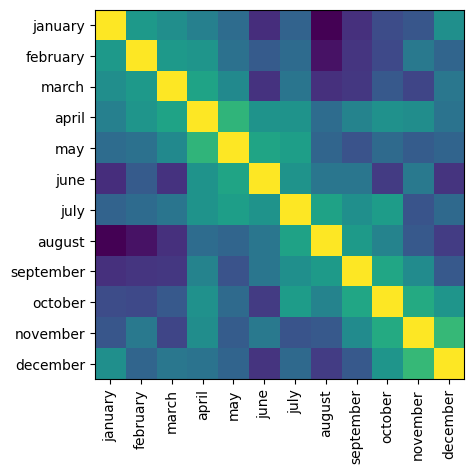

In [ ]:
# plot similarities among concepts in the specific ('well-defined') domain of time

months = ['january','february','march',
          'april','may','june',
          'july','august','september',
          'october','november','december']
s = [['the academic year will begin in ' + month] + [month] for month in months] # build input list

e = model_bert.extract_representation(s) # extract CWE

# plot results (do we see a cyclic pattern?)
plt.xticks(np.arange(0,12), labels = months, rotation = 90)
plt.yticks(np.arange(0,12), labels = months)
plt.imshow(sim(e))


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.1.1)}}$ Try playing with your own words and sentences. Do you feel that BERT matches your intuitions of semantic similarity?
*   $\color{red}{\text{(e.1.2)}}$ Try the 'months' example with days of the week. Do you feel the cyclic nature of time is reflected in the similarity among days? What is the impact of the context in which each day is embedded?
*   $\color{red}{\text{(e.1.3)}}$ Evaluate the following code:
  ```
  s = [['it is now ' + str(n) + ' minutes past 3.'] + [str(n)] for n in range(0,61)]
  e = model_bert.extract_representation(s)
  plt.imshow(sim(e))
  ```
  What does the code display? Do you notice some peculiar patterns?
*   $\color{red}{\text{(e.1.4)}}$ Try to come up with a domain where you expect to find a bias similar to that of $\text{(e.1.3)}$.

In [ ]:
# @title ###### exercise 1.2 - solution

days = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
prompt = 'let\'s meet on ' # or 'we are closed on '
s = [[prompt + day] + [day] for day in days]

e = model_bert.extract_representation(s)

plt.xticks(np.arange(0,len(s)), labels = days, rotation = 90)
plt.yticks(np.arange(0,len(s)), labels = days)
plt.imshow(sim(e))


In [ ]:
# @title ###### exercise 1.3 - solution

s = [['it is now ' + str(n) + ' minutes past 3.'] + [str(n)] for n in range(0,61)]
e = model_bert.extract_representation(s)
plt.imshow(sim(e))

# notice the gridlike pattern at intervals of five (possibly a consequence of
# the higher frequency of those values) and the low similairity band at n = 3,
# probably resulting from having '3' later on in the sequence (indeed, try other
# numbers and see what happens!)


In [ ]:
# @title ###### exercise 1.4 - solution

# an example with money
s = [['This drill costs ' + str(n) + ' bucks.'] + [str(n)] for n in range(0,61)]
e = model_bert.extract_representation(s)
plt.title('similarity among item prices')
plt.imshow(sim(e))



<br>

### **1.2. CWE: longer sequences and complex words**


---

how the language models handles words that are morphologically complex and/or novel

In [ ]:
# import tokenizer

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # the tokenizer breaks a sequence down into a number of subword tokens

In [ ]:
# tokenize expressions

tokenizer.tokenize('inspect the tokenization of a sentence')
tokenizer.tokenize('attention: complex words can be decomposed in in unforeseeable ways')

# how does the tokenizer deal with novel words that are outside its vocabulary?
tokenizer.tokenize('''
“Beware the Jabberwock, my son!
      The jaws that bite, the claws that catch!
Beware the Jubjub bird, and shun
      The frumious Bandersnatch!”
''') # from Lewis Carrol's 'Jabberwocky'


In [ ]:
# extract embeddings of multitoken sequences

tokenizer.tokenize("simple phrase")

v = model_bert.extract_representation([
    ["simple phrase","simple"],
    ["simple phrase","phrase"],
    ["simple phrase","simple phrase"]])

torch.equal(v[2,],(v[0,]+v[1,])/2) # note that embeddings are by default averaged by extract_representation


In [ ]:
# extract sentence embeddings

v_s = model_bert.extract_sentence_representation("simple phrase", layer = 12, pooler = "mean") # specify layer and pooling strategy
v = model_bert.extract_representation(["simple phrase","simple phrase"], layer = 12)

torch.equal(v,v_s) # sentence embeddings =/= combination of token embeddings (note that this depends on the specific model)


In [ ]:
# extract subword embeddings

s = "The frumious Bandersnatch!" # what if we want the embedding of the '##nat' token?
tokenizer.tokenize(s)

# model_bert.extract_representation(s,"##nat", layer = 12) # error!

token_pos = tokenizer.tokenize(s).index("##nat") # get token position
token_v = model_bert.encode_text(s, layer = 12)[1][0, token_pos + 1,:] # NOTE! depends on the model (here, BERT special tokens 101 and 102)


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.1.5)}}$ Play with the tokenizer using your own sentences and words. Tokenize the following sentences:
```
s1 = 'This item is unavailable.'
s2 = 'This door is unlockable.'
s3 = 'This track is unbeatable.'
s4 = 'This change was unforeseeable'
```
What do you notice?


In [ ]:
# @title ###### exercise 1.5 - solution

s1 = 'This item is unavailable.'
s2 = 'This door is unlockable.'
s3 = 'This track is unbeatable.'
s4 = 'This change was unforeseeable'
print(tokenizer.tokenize(s1))
print(tokenizer.tokenize(s2))
print(tokenizer.tokenize(s3))
print(tokenizer.tokenize(s4)) # tokenization does not always respect appropriate decomposition!



<br>

### **1.3. CWE: embeddings along layers and contextualization**


---

Extract CWE from different layers of a language model to probe the impact of context

#### **1.3.1. different words, same context**

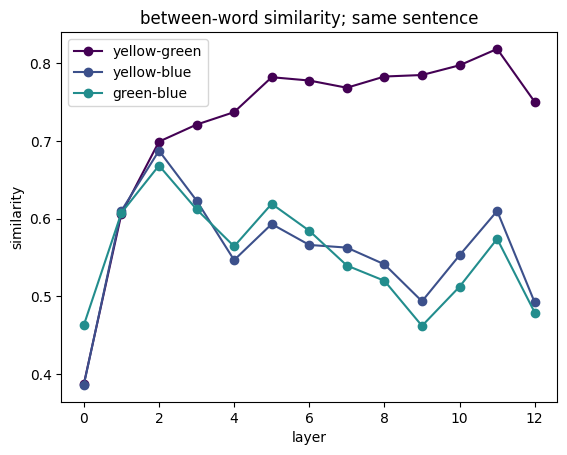

In [ ]:
### get and plot similarities between the same words in the same sentence

N_layers = model_bert.layers

sentence = 'the fields are yellow and green, the sky is blue'
target_words = ['yellow','green','blue']
sequences = [[sentence, word] for word in target_words]

# get embeddings and similarities
C = []
for L in range(0,N_layers+1): # for each layer
  embeddings = model_bert.extract_representation(sequences, layer = L)
  sim_matrix = sim(embeddings)
  sim_matrix = sim_matrix.unsqueeze(0) # add the third dimension (i.e., layer)
  C.append(sim_matrix)
C = torch.cat(C, dim = 0) # concatenate along third dimension

# plot similarities along layers
cmap = plt.get_cmap('viridis')
color_indexes = list(range(0,255,255//(len(target_words)+1)-1))

c_index = 0
for w1 in range(len(target_words)):
  for w2 in range(w1+1,len(target_words)):
    plt.plot(C[:,w1,w2], label = target_words[w1] + '-' + target_words[w2], color = cmap(color_indexes[c_index]), linestyle = '-', marker = 'o')
    c_index = c_index + 1

plt.xlabel('layer')
plt.ylabel('similarity')
plt.title('between-word similarity; same sentence')
plt.legend()



#### **1.3.2. same words, different context**

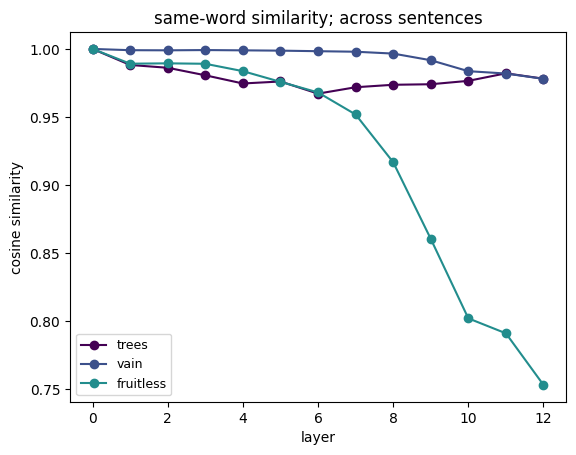

In [ ]:
### get and plot similarities between the same words in different sentential contexts

N_layers = model_bert.layers

sentence = ['we tried in vain to repel the bugs from our trees; all solutions were fruitless!',
            'we tried in vain to repel the bugs from our trees; all plants were fruitless!']
target_words = ['trees','vain','fruitless']

# get embeddings and similarities
C = []
for w1 in range(len(target_words)):
  c = []
  for L in range(0,N_layers+1):
    sequences = [[sentence[0],target_words[w1]],[sentence[1],target_words[w1]]]
    embeddings = model_bert.extract_representation(sequences, layer = L)
    c.append(sim_pair(embeddings[0],embeddings[1]).unsqueeze(-1))
  c = torch.cat(c, dim = 0)
  C.append(c)

# plot similarities
c_index = 0
for w1 in range(len(target_words)):
  plt.plot(C[w1], label = target_words[w1], color = cmap(color_indexes[c_index]), linestyle = '-', marker = 'o')
  c_index = c_index + 1

plt.xlabel('layer')
plt.ylabel('cosine similarity')
plt.title('same-word similarity; across sentences')
plt.legend(fontsize = 9)


#### **1.3.3. different words, different context**

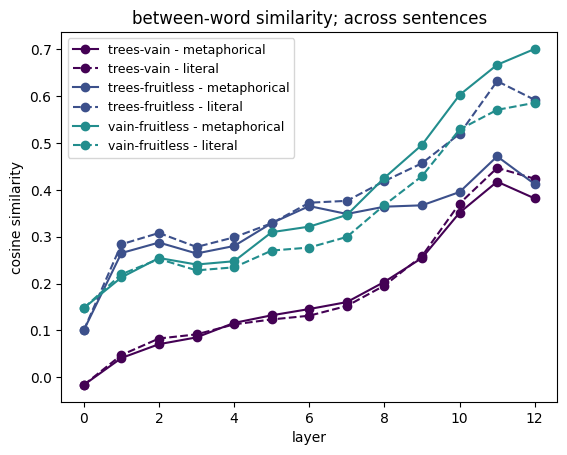

In [ ]:
### get and plot similarities between different words in different sentential contexts

N_layers = model_bert.layers

sentence = ['we tried in vain to repel the bugs from our trees; all solutions were fruitless!',
            'we tried in vain to repel the bugs from our trees; all plants were fruitless!']
target_words = ['trees','vain','fruitless']

# get embeddings and similarities
C = []
for s in range(0,2):
  c = []
  for L in range(0,N_layers+1): # for each layer
    sequences = [[sentence[s], word] for word in target_words]
    embeddings = model_bert.extract_representation(sequences, layer = L)
    c.append(sim(embeddings).unsqueeze(0)) # add the third dimension (i.e., layer)
  c = torch.cat(c, dim = 0) # concatenate along third dimension
  C.append(c.unsqueeze(0))
C = torch.cat(C, dim = 0) # concatenate along fourth dimension

# plot similarities
c_index = 0
for w1 in range(len(target_words)):
  for w2 in range(w1+1,len(target_words)):
    plt.plot(C[0,:,w1,w2], label = target_words[w1] + '-' + target_words[w2] + ' - metaphorical', color = cmap(color_indexes[c_index]), linestyle = '-', marker = 'o')
    plt.plot(C[1,:,w1,w2], label = target_words[w1] + '-' + target_words[w2] + ' - literal', color = cmap(color_indexes[c_index]), linestyle = '--', marker = 'o')
    c_index = c_index + 1

plt.xlabel('layer')
plt.ylabel('cosine similarity')
plt.title('between-word similarity; across sentences')
plt.legend(fontsize = 9)


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.1.6)}}$ Explore the effect of contextualization using your own words and sentences. Try to come up with a context that makes the embeddings of two words with typically different meaning *converge*. For example, come up with a sentence where 'just' and 'fair' have a similar representaion, and one where their representaion differs. Use the code of 1.3.3. and include a third word to account for the baseline similarity trend (i.e., how the similarity between 'vain' and 'tree' made us aware of a baseline increase of cosine similairities along BERT's depth).

In [ ]:
# @title ###### exercise 1.6 - solution

N_layers = model_bert.layers

sentence = ['The point is: It was just a matter of time until we got to the fun fair.',
            'The point is: what is just for the law system may not be fair to us.']
target_words = ['point','just','fair']

# get embeddings and similarities
C = []
for s in range(0,2):
  c = []
  for L in range(0,N_layers+1): # for each layer
    sequences = [[sentence[s], word] for word in target_words]
    embeddings = model_bert.extract_representation(sequences, layer = L)
    c.append(sim(embeddings).unsqueeze(0)) # add the third dimension (i.e., layer)
  c = torch.cat(c, dim = 0) # concatenate along third dimension
  C.append(c.unsqueeze(0))
C = torch.cat(C, dim = 0) # concatenate along fourth dimension

# plot similarities
c_index = 0
for w1 in range(len(target_words)):
  for w2 in range(w1+1,len(target_words)):
    plt.plot(C[0,:,w1,w2], label = target_words[w1] + '-' + target_words[w2] + ' - different sense', color = cmap(color_indexes[c_index]), linestyle = '-', marker = 'o')
    plt.plot(C[1,:,w1,w2], label = target_words[w1] + '-' + target_words[w2] + ' - same sense', color = cmap(color_indexes[c_index]), linestyle = '--', marker = 'o')
    c_index = c_index + 1

plt.xlabel('layer')
plt.ylabel('cosine similarity')
plt.title('between-word similarity; across sentences')
plt.legend(fontsize = 9)


<br>

### **1.4. CWE: comparing models**

---

models can be compared in the extent they represent similar information

#### **1.4.1. different languages**

A dimension where LLMs can different is the language they have been trained on. On Hugging Face one can find monolingual models for *many* languages (as well as multilingual models; see https://huggingface.co/models). Focusing on BERT, here is a list of monolingual models trained on common languages:

```
google-bert/bert-base-uncased # English
google-bert/bert-base-chinese
google-bert/bert-base-german-cased
dccuchile/bert-base-spanish-wwm-uncased
neuralmind/bert-base-portuguese-cased
almanach/camembert-base # French
dbmdz/bert-base-italian-uncased
dbmdz/bert-base-turkish-uncased
asafaya/bert-base-arabic
DeepPavlov/rubert-base-cased # Russian
tohoku-nlp/bert-base-japanese
```

Google also provides a *multilingual* version of BERT trained on 104 languages:
```
google-bert/bert-base-multilingual-cased
```


In [ ]:
# Let's look at a monolingual BERT in another language

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_bert_EN = cwe.CWE('google-bert/bert-base-uncased', device = my_device)
model_bert_IT = cwe.CWE('dbmdz/bert-base-italian-cased', device = my_device)

In [ ]:
# define some sentences in English and their translation in another language (here, Italian)

sents_EN = ['I like to eat an apple after lunch.',
            'sometimes I wonder why aliens do not come visit us.',
            'Would you like to add some salt?',
            'I go to bed late and wake up early',
            'I prefer the comic book to the movie',
            'the city is nice, but I wouldn\'t live there',
            'there is nothing worse than a boring sentence',
            'sharks are among the biggest sea predators']

sents_IT = ['Mi piace mangiare una mela dopo pranzo.',
            'a volte mi domando perchè gli alieni non ci fanno visita.',
            'Vorresti aggiungere del sale?',
            'Vado a letto tardi e mi sveglio presto',
            'Preferisco il fumetto al film',
            'la città è bella, ma non ci vivrei',
            'non c\'è nulla di peggio di una frase noiosa',
            'gli squali sono tra i più grandi predatori marini']


In [ ]:
# extract sentence embeddings

v_EN = model_bert_EN.extract_sentence_representation(sents_EN, layer = 12)
v_IT = model_bert_IT.extract_sentence_representation(sents_IT, layer = 12)

#### **1.4.2. comparing representations**

Consider two models that represent similar information, such as two LLMs with similar architecture and objectives but trained on different languages. While their embeddings cannot be *direnctly* compared (different coordinate systems, often different dimensionality), we can expect that items that are represented similarly in one model (e.g., the embeddings of "tulip" and "tree" in an English LLM) will be similar in the other (e.g., their Italian counterparts, "tulipano" and "albero", in an Italian LLM, or 郁金香 and 树 in a simplified Chinese LLM).

<center>
  <img src="https://drive.google.com/uc?export=view&id=1Oms80CcQTwJzYpidV0W26457yiA8g4wV" width="500"/>
</center>

---

**representational similarity analysis (RSA)** is a technique, popularized in neuroscience, that tests such similarities. Consider a list of concept embeddings ${\bf c_1}, {\bf c_2}, ..., {\bf c_n}$ in the two spaces $a$ and $b$. First, we build the matrix of all pairwise similaities among concepts in space $a$, obtaining the *representational similarity matrix* $RSM_a$:

$$
RSM_{a[i,j]} = \cos({{\bf c_i^a},{\bf c_j^a}})
$$

We repeat the process for $b$, building $RSM_b$. Finally, we compute the correlation among the upper-triangular part of $RSM_a$ and of $RSM_b$ as a measure of how similarly concepts are represented in the two spaces:

$$
RSA_{ab}=r(RSM_{a[i,j>i]},RSM_{b[i,j>i]})
$$

In [ ]:
# define a function to perform representational similarity analysis (RSA) between pairs of 2D RSMs

def rsa(rsm1,rsm2): # NOTE: you can use the function sim() to create RSMs!

  if (rsm1.shape == rsm2.shape):
    upper_indices = torch.triu_indices(rsm1.shape[0], rsm1.shape[1], offset = 1)
    rsm1 = rsm1[upper_indices[0], upper_indices[1]]
    rsm2 = rsm2[upper_indices[0], upper_indices[1]]

    r = torch.corrcoef(torch.stack([rsm1, rsm2]))
    r = r[0,1]
    return r
  else:
    print('RSMs dimensions do not match')


The representational similarity score between the two language spaces is: r = 0.8345258


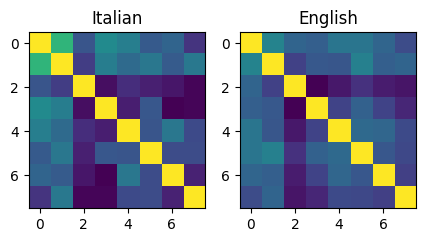

In [ ]:
# Let's now compare the second-order similarity of sentences in different LLMs

f, axarr = plt.subplots(1,2, figsize = (5,5))

axarr[0].imshow(sim(v_IT))
axarr[0].set_title('Italian')
axarr[1].imshow(sim(v_EN))
axarr[1].set_title('English')

RSA_score = rsa(sim(v_EN),sim(v_IT))
print('The representational similarity score between the two language spaces is: r = ' + str(RSA_score.numpy()))


100%|██████████| 13/13 [00:00<00:00, 19.99it/s]


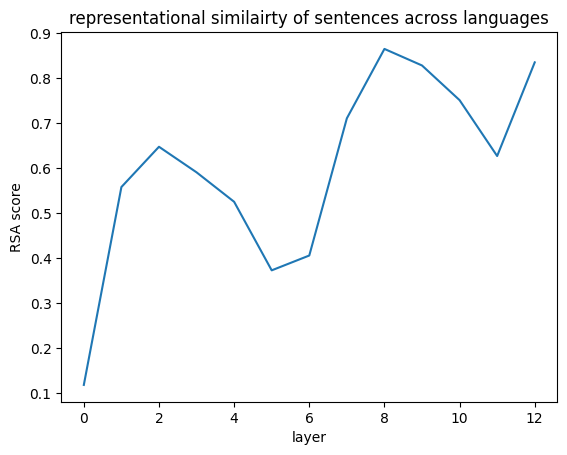

In [ ]:
# see how alignment unflods along models' depth

aligned = torch.empty(0)
for L in tqdm(range(0,model_bert_EN.layers + 1)):
  v_EN = model_bert_EN.extract_sentence_representation(sents_EN, layer = L)
  v_IT = model_bert_IT.extract_sentence_representation(sents_IT, layer = L)
  RSA_score = rsa(sim(v_EN),sim(v_IT))

  aligned = torch.cat((aligned,RSA_score.unsqueeze(0)), dim = 0)

# plot results
plt.xlabel('layer')
plt.ylabel('RSA score')
plt.title('representational similairty of sentences across languages')
plt.plot(aligned)


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.1.7)}}$ Play with another language! Download a model trained on your language (not necessarily a BERT model) and see how much the same content is represented similarly in English and in your language. If you cannot find a model in your language, you can try multilingual BERT ('google-bert/bert-base-multilingual-cased'). If you only speak English, you can download another English model and anticipate the next topic(s) by comparing different models on the same sentences (e.g., look at GPT-2: 'openai-community/gpt2')
*   $\color{red}{\text{(e.1.8)}}$ Do a sanity check of RSA results. What happens if you swap the model-sentence pairing? (e.g., Italian sentences to an English model).
*   $\color{red}{\text{(e.1.9)}}$ Try doing the above along layers: take the code we used to plot RSA scores along layers, but now plot RSA scores with swapped model-sentence pairings. Specifically, plot the difference between 'correct' RSA scores (computed from true model-sentence language pairings) and 'swapped' scores (computed from swapped model-sentence language pairings).

In [ ]:
# @title ###### exercise 1.8 - solution

v_EN = model_bert_EN.extract_sentence_representation(sents_IT, layer = 12) # swap the input
v_IT = model_bert_IT.extract_sentence_representation(sents_EN, layer = 12) # similarly, swap the language of the sentences
RSA_score_swapped = rsa(sim(v_EN),sim(v_IT))

f, axarr = plt.subplots(1,2, figsize = (5,5))

axarr[0].imshow(sim(v_IT))
axarr[1].imshow(sim(v_EN))

print('The representational similarity score between the two (inverted) spaces is: r = ' + str(RSA_score_swapped.numpy()))


In [ ]:
# @title ###### exercise 1.9 - solution

diff = torch.empty(0)

for L in tqdm(range(0,model_bert_EN.layers + 1)):
  v_EN = model_bert_EN.extract_sentence_representation(sents_EN, layer = L)
  v_IT = model_bert_IT.extract_sentence_representation(sents_IT, layer = L)
  RSA_score = rsa(sim(v_EN),sim(v_IT))

  v_EN = model_bert_EN.extract_sentence_representation(sents_IT, layer = L)
  v_IT = model_bert_IT.extract_sentence_representation(sents_EN, layer = L)
  RSA_score_swapped = rsa(sim(v_EN),sim(v_IT))

  RSA_diff = RSA_score - RSA_score_swapped
  diff = torch.cat((diff,RSA_diff.unsqueeze(0)), dim = 0)

# plot results
plt.xlabel('layer')
plt.ylabel('RSA score difference')
plt.hlines(0, 0, model_bert_EN.layers, colors = 'red', linestyles = 'dashed')
plt.title('effect of correct model-sentence pairings on RSA')
plt.plot(diff)


We can apply the same procedure to compae different layers *of the same model*, to explore how representations drift along model depths.

100%|██████████| 13/13 [00:07<00:00,  1.74it/s]


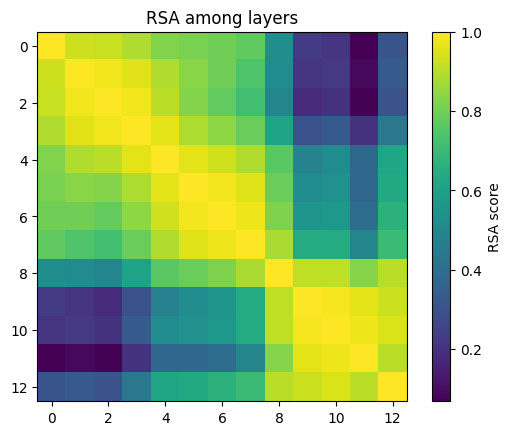

In [ ]:
# RSA scores among all layers of a BERT model

N_layers = model_bert_EN.layers # number of layers of the target model
RSA_table = torch.zeros(N_layers + 1,N_layers + 1)

for Li in tqdm(range(0,N_layers + 1)):
  v_Li = model_bert_EN.extract_sentence_representation(sents_EN, layer = Li)

  for Lj in range(0,N_layers + 1):
    v_Lj = model_bert_EN.extract_sentence_representation(sents_EN, layer = Lj)
    RSA_table[Li,Lj] = rsa(sim(v_Li),sim(v_Lj)) # RSA between later i and j

plt.imshow(RSA_table)
plt.title('RSA among layers')
plt.colorbar(label = "RSA score")


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.1.10)}}$ What about comparing different layers *across languages*? Generate the plot above, but this time the cells below the diagonal should code for the RSA scores among layers of a different language model. For example, the cell (6,3) should code for the RSA score between layer 3 of language 1 (English) and layer 6 of language 2 (e.g., Italian). The cell (3,6) should report the RSA score between layer 3 and 6 of the same language (English).

In [ ]:
# @title ###### exercise 1.10 - solution

# RSA scores among all layers of BERT models, across languages

N_layers = model_bert_EN.layers # number of layers of the English model (note: equal number of layers for the Italian model)
RSA_table = torch.zeros(N_layers + 1,N_layers + 1)

for Li in tqdm(range(0,N_layers + 1)):
  v_Li = model_bert_EN.extract_sentence_representation(sents_EN, layer = Li)

  for Lj in range(Li + 1, N_layers + 1): # consider only layers where j > i

    v_Lj = model_bert_EN.extract_sentence_representation(sents_EN, layer = Lj) # same language
    RSA_table[Li,Lj] = rsa(sim(v_Li),sim(v_Lj))

    v_Lj = model_bert_IT.extract_sentence_representation(sents_IT, layer = Lj) # different language
    RSA_table[Lj,Li] = rsa(sim(v_Li),sim(v_Lj)) # flip indexes to populate the lower-triangular matrix

plt.imshow(RSA_table)
plt.title('RSA among the layers of same (upper-diagonal) \n and different (lower-diagonal) models')
plt.colorbar(label = "RSA score")


<br>

# **2. scorer module**

---

---

---

<br>

In [ ]:
# @title ###### **(re-load and re-define functionalities** -- if runtime error)

# this cell can be used to import libraries, define functions and load models in
# case the runtime is disconnected (e.g., when switching between CPU and GPU)

# import -----------------------------------------------------------------------

!pip install minicons

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import minicons
from minicons import cwe
from minicons import scorer

# define similarity funtions ---------------------------------------------------

def sim_pair(tensor_a,tensor_b):
  norm_a = tensor_a.norm(p = 2)
  norm_b = tensor_b.norm(p = 2)
  dot_prod = torch.dot(tensor_a, tensor_b)
  cosine = dot_prod / (norm_a * norm_b) # use formula
  return cosine

def sim(tensors):
  cosine_similarities = torch.zeros((len(tensors), len(tensors)))
  for i in range(len(tensors)):
    for j in range(len(tensors)):
      cosine_similarities[i,j] = sim_pair(tensors[i,], tensors[j,])
  return cosine_similarities

def rsa(rsm1,rsm2):

  if (rsm1.shape == rsm2.shape):
    upper_indices = torch.triu_indices(rsm1.shape[0], rsm1.shape[1], offset = 1)
    rsm1 = rsm1[upper_indices[0], upper_indices[1]]
    rsm2 = rsm2[upper_indices[0], upper_indices[1]]

    r = torch.corrcoef(torch.stack([rsm1, rsm2]))
    r = r[0,1]
    return r
  else:
    print('RDMs dimensions do not match')

# import models ----------------------------------------------------------------

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_gpt2 = scorer.IncrementalLMScorer('openai-community/gpt2', device = my_device)
bert_scorer = scorer.MaskedLMScorer('google-bert/bert-base-uncased', device = my_device)
model_bert = cwe.CWE('google-bert/bert-base-uncased', device = my_device)

In [ ]:
# import module

from minicons import scorer

<br>

### **2.1. scorer: compute surprisal**


---

extract the surprisal scores of target tokens or sequences

**surprisal** is the negative log-probability of observing a word (or token) given a sequence of words (or tokens):

<br>

\begin{equation}
surprisal ({w_i})= -{\log{P(w_i|w_1,w_2,...,w_{i-1})}}
\end{equation}

<br>

---

NOTE:

surprisal extraction differs between autoregressive models (e.g., GPT) and masked language models (e.g., BERT). In code:


```
scorer.IncrementalLMScorer() # autoregressive models
scorer.MaskedLMScorer() # masked language models
```



In [ ]:
# import language model

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_gpt2 = scorer.IncrementalLMScorer('openai-community/gpt2', device = my_device) # from https://huggingface.co/models

In [ ]:
# get token log-probabilities and surprisals

sentences = ["she has just got many new books and has already read them all!"]

# log-probabilities
logprobs = model_gpt2.compute_stats(model_gpt2.prepare_text(sentences), base_two = True, return_tensors = False)
# log-probabilities and tokens
logprobs2 = model_gpt2.token_score(sentences, base_two = True)
# surprisals and tokens
surprisals = model_gpt2.token_score(sentences, surprisal = True, base_two = True)

print(logprobs)
print(logprobs2)
print(surprisals)


In [ ]:
# estimate sentence grammaticality with token and sequence surprisal

sentences = ["she has just got many new books and has already read them all!",
             "she have just got many new books and has already read them all!",
             "she has just got many new books and has already read it all!",
             "she have just got many new books and has already read it all!"]

t_surprisals = model_gpt2.token_score(sentences, surprisal = True, base_two = True) # base-2 surprisals
t_logprobs = model_gpt2.token_score(sentences, surprisal = False, base_two = True) # base-2 log-probabilities

# average token log-probabilities
s_logprobs = model_gpt2.sequence_score(sentences) # if sum rather than average: reduction = lambda x: x.sum(0)

In [ ]:
# conditional log-probabilities

# obtain the probability of a sequence (post) conditioned on another (pre)
pre = ['London is the capital of',
       'Bristol is the capital of',
       'Paris is the capital of',
       'Marseilles is the capital of',
       'GPT is the capital of']
post = ['England'] * len(pre)

cond_scores = model_gpt2.conditional_score(pre, post) # log P(post|pre)
list(zip([p + ' ' + post[0] for p in pre], cond_scores))


[('London is the capital of England', -3.591094970703125),
 ('Bristol is the capital of England', -5.073600769042969),
 ('Paris is the capital of England', -6.313713073730469),
 ('Marseilles is the capital of England', -7.80322265625),
 ('GPT is the capital of England', -7.5289154052734375)]

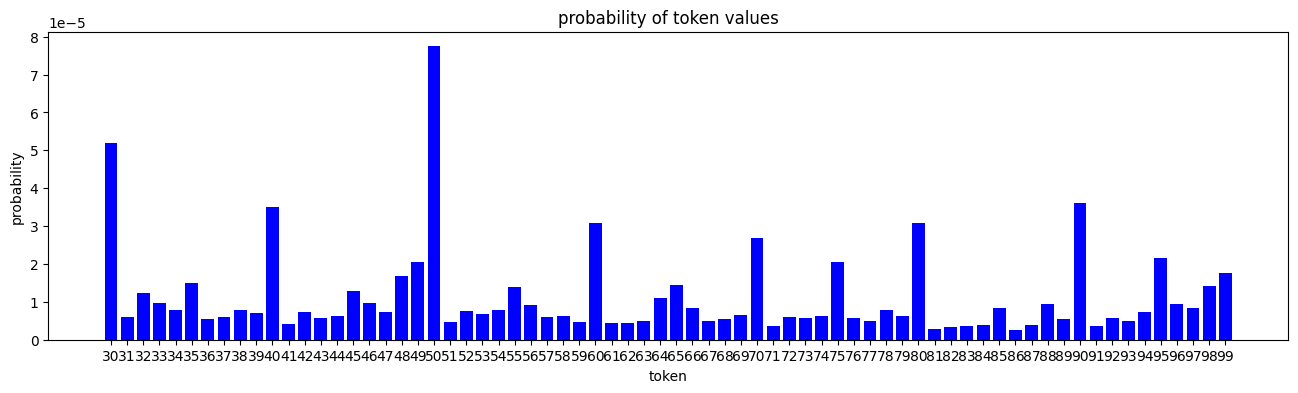

In [ ]:
# explore some 'known patterns' in item pricing

post = [str(n) for n in range(30,100)]
pre = ['The TV costs $180.'] * len(post) # define possible prices for a TV

cond_scores = model_gpt2.conditional_score(pre, post, prob = True)

plt.figure(figsize = (16, 4))
plt.bar(post, cond_scores, color = 'blue')
plt.xlabel("token")
plt.ylabel("probability")
plt.title("probability of token values")
plt.show()


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.2.1)}}$ Try your own sequences to test the "knowledge" of the model.
*   $\color{red}{\text{(e.2.2)}}$ Let's look at a condition where *we* create the 'ground-truth': numerical sequences. Use `conditional_score` to probe the probability estimates of the following sequence continuations (post): `['0','1','2','3','4','5','6','7','8','9','-']` given a numerical sequence (pre; e.g., 1-2-3-4-)
*   $\color{red}{\text{(e.2.3)}}$ According to GPT-2, what are the most likely minutes to schedule a meeting between 16:00 and 17:00? Plot the results.

In [ ]:
# @title ###### exercise 2.2 - solution

post = ['0','1','2','3','4','5','6','7','8','9','-']
pre = ['1-2-3-1-2-3-1-2-3-1-2-3-1-2-3-1-2-3-'] * len(post)

cond_scores = model_gpt2.conditional_score(pre, post, prob = True) # log P(post|pre)
list(zip(post, cond_scores))


In [ ]:
# @title ###### exercise 2.3 - solution

post = [str(n) for n in range(0,71)] # include 16:61 to 16.71 as a sanity check
pre = ['The meeting is scheduled at 16:'] * len(post)

cond_scores = model_gpt2.conditional_score(pre, post, prob = True) # log P(post|pre)

plt.figure(figsize = (16, 4))
plt.bar(post, cond_scores, color = 'blue')
plt.xlabel("minutes")
plt.xticks(rotation = 90)
plt.ylabel("probability")
plt.title("probability of token values after the sequence: \n '" + pre[0] + "'")
plt.show()


<br>

### **2.2 scorer: batch processing**

---

Let's look again at the influence of context on word meaning, this time using an external dataset, the Words in Cotext (WiC):
<small>
> Pilehvar, M. T., & Camacho-Collados, J. (2018). WiC: the word-in-context dataset for evaluating context-sensitive meaning representations. arXiv preprint arXiv:1808.09121.
</small>

with annotations from:
<small>
> Cassani, G., Günther, F., Attanasio, G., Bianchi, F., & Marelli, M. (2023). Meaning Modulations and Stability in Large Language Models: An Analysis of BERT Embeddings for Psycholinguistic Research.
</small>

We can use *batch processing* to prepare batch computations. Note that, to be run at sufficient speed, the code cell below should be run when connected to a **GPU** or a **TPU** (change runtime if you are connected to a CPU).

In [ ]:
# (option 1) load WiC from a Drive folder

from google.colab import drive
drive.mount('/content/drive') # connect your Drive to Colab

# load WiC dataset
file_path = '/content/drive/My Drive/LLMs_for_psyling/' # your path to the file
file_name = 'wic_dataset_annotated.csv'

# df = open(file_path + file_name)
df = pd.read_csv(file_path + file_name, encoding = 'unicode_escape') # load WiC as dataframe
df.head(10) # display the first 10 rows


In [ ]:
# (option 2) load from local machine

from google.colab import files
uploaded = files.upload() # select file in local

file_name = 'wic_dataset_annotated.csv'
df = pd.read_csv(file_name)
df.head(10) # display the first 10 rows


Preprocess the WiC dataset. Each target word is used in two sentences in a different sense, and is replaced by a sense-appropriate and sense-inappropriate word. Our goal is to see if appropriate replacements are less surprising (scorer module) than inappropriate ones, and whether the embeddings of appropriate replacements deviates less from the embeddings of the original words as opposed to those of inappropriate replacements (CWE module).

In [ ]:
# define words and contexts

target = df['Target'].to_list() # target words

s1 = df['sent1'].to_list() # sentences 1st sense
s2 = df['sent2'].to_list() # sentences 2nd sense

syn_s1 = df['synonym_sent1'].to_list() # synonym 1st sense
syn_s2 = df['synonym_sent2'].to_list() # synonym 2nd sense

# combine words and contexts
target_s1 = list(zip(s1,target))
target_s2 = list(zip(s2,target))

appropriate_s1 = []
inappropriate_s1 = []
for s in range(len(s1)):
  appropriate_s1.append([s1[s].replace(target[s], syn_s1[s]),syn_s1[s]])
  inappropriate_s1.append([s1[s].replace(target[s], syn_s2[s]),syn_s2[s]])

appropriate_s2 = []
inappropriate_s2 = []
for s in range(len(s2)):
  appropriate_s2.append([s2[s].replace(target[s], syn_s2[s]),syn_s2[s]])
  inappropriate_s2.append([s2[s].replace(target[s], syn_s1[s]),syn_s1[s]])


<br>

###### **surprisal**

In [ ]:
# import *MLM* scorer

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
bert_scorer = scorer.MaskedLMScorer('google-bert/bert-base-uncased', device = my_device) # from https://huggingface.co/models

appropriate sense -- batches:
('His discussion of the race question is badly biased .', 'They always sat on the right part of the church .', 'The program was on the airwave from 9 til midnight .', 'A sunburnt skin .', 'He came to a bad ending .', 'The guild of Saint Benedict .', 'The clash between the government and the rebels began three years ago .', 'A feeling of happiness .', 'He had a great intuition for music .', 'The open frame in the eighth frame cost him the match .')
('It brought out his better part .', 'The tip of the compass needle is pointing due north .', 'City kids get to see the country at a summer campground .', 'He tried to blame the victim but his success on that account was doubtful .', "I could n't tell what the matter was .", 'This is a substance of lime and nitric acid .', 'His instructions deliberately gave them the wrong readiness .', 'The sole goal of her trip was to see her children .', 'A homeless vagrant .', 'Slices of hard-boiled egg on a layer of spinach 

Text(0.5, 0, 'surprisal difference (appropriate - inappropriate)')

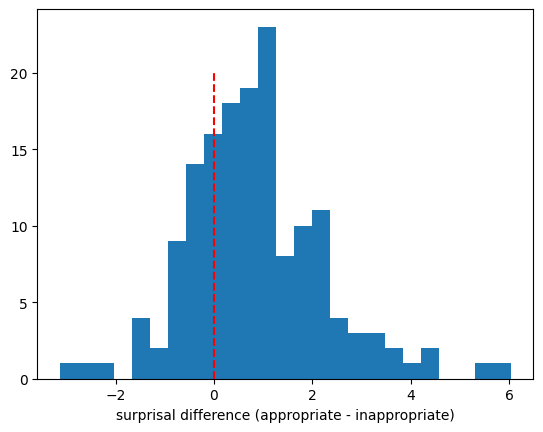

In [ ]:
# compute surprisals in batches

from torch.utils.data import DataLoader

N_sentences = len(target_s1) # iterate over the whole dataset

stimuli_dl = DataLoader(appropriate_s1[0:N_sentences], batch_size = 10) # compute in batches of N sentences
surprisals_app = []
print("appropriate sense -- batches:")
for batch in stimuli_dl:
  s, w = batch
  print(s)
  seq = bert_scorer.sequence_score(list(s), reduction = lambda x: -x.mean(0).item(), PLL_metric = 'within_word_l2r')
  surprisals_app.append(seq)

stimuli_dl = DataLoader(inappropriate_s1[0:N_sentences], batch_size = 10) # compute in batches of N sentences
surprisals_inapp = []
print("inappropriate sense -- batches:")
for batch in stimuli_dl:
  s, w = batch
  print(s)
  seq = bert_scorer.sequence_score(list(s), reduction = lambda x: -x.mean(0).item(), PLL_metric = 'within_word_l2r')
  surprisals_inapp.append(seq)

# plot surprisals
flattened_list_app = np.array([item for sublist in surprisals_app for item in sublist])
flattened_list_inapp = np.array([item for sublist in surprisals_inapp for item in sublist])
plt.hist(flattened_list_inapp - flattened_list_app, bins = 25)
plt.vlines(0,0,20,colors = 'red', linestyles = 'dashed')
plt.xlabel('surprisal difference (appropriate - inappropriate)')

<br>

###### **CWE**

  0%|          | 0/13 [00:00<?, ?it/s]

0


  8%|▊         | 1/13 [00:04<00:55,  4.60s/it]

1


 15%|█▌        | 2/13 [00:07<00:40,  3.67s/it]

2


 23%|██▎       | 3/13 [00:09<00:30,  3.03s/it]

3


 31%|███       | 4/13 [00:11<00:23,  2.64s/it]

4


 38%|███▊      | 5/13 [00:14<00:19,  2.49s/it]

5


 46%|████▌     | 6/13 [00:16<00:18,  2.58s/it]

6


 54%|█████▍    | 7/13 [00:18<00:14,  2.40s/it]

7


 62%|██████▏   | 8/13 [00:20<00:11,  2.28s/it]

8


 69%|██████▉   | 9/13 [00:22<00:08,  2.21s/it]

9


 77%|███████▋  | 10/13 [00:24<00:06,  2.14s/it]

10


 85%|████████▍ | 11/13 [00:27<00:04,  2.15s/it]

11


 92%|█████████▏| 12/13 [00:30<00:02,  2.37s/it]

12


100%|██████████| 13/13 [00:32<00:00,  2.46s/it]


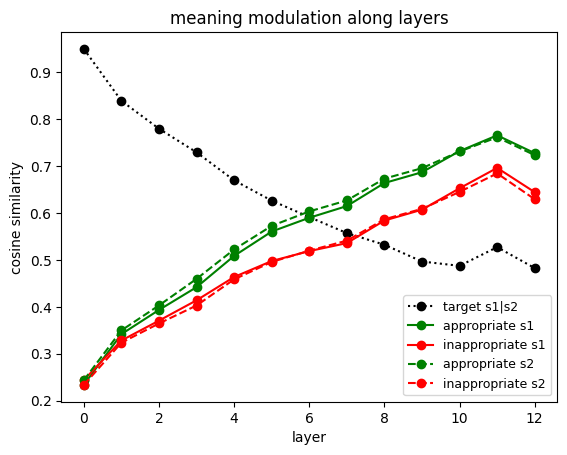

In [ ]:
# get embeddings and compute similairty

N_layers = model_bert.layers
N_sentences = len(target_s1)

S = np.empty((N_layers + 1,5))

for L in tqdm(range(0,N_layers+1)):

  print(L)
  sims = np.empty((N_sentences,5))
  for s in range(0,N_sentences):

    contexts = [target_s1[s],appropriate_s1[s],inappropriate_s1[s],target_s2[s],appropriate_s2[s],inappropriate_s2[s]]
    e = model_bert.extract_representation(contexts, layer = L)
    sims[s][0] = sim_pair(e[0,],e[3,]).numpy() # target s1|s2
    sims[s][1] = sim_pair(e[0,],e[1,]).numpy() # appropriate s1
    sims[s][2] = sim_pair(e[0,],e[2,]).numpy() # inappropriate s1
    sims[s][3] = sim_pair(e[3,],e[4,]).numpy() # appropriate s2
    sims[s][4] = sim_pair(e[3,],e[5,]).numpy() # inappropriate s2
  S[L,] = sims.mean(axis = 0)

# plot results along layers
plt.plot(S[:,0], label = 'target s1|s2', color = 'black', linestyle = ':', marker = 'o')
plt.plot(S[:,1], label = 'appropriate s1', color = 'green', linestyle = '-', marker = 'o')
plt.plot(S[:,2], label = 'inappropriate s1', color = 'red', linestyle = '-', marker = 'o')
plt.plot(S[:,3], label = 'appropriate s2', color = 'green', linestyle = '--', marker = 'o')
plt.plot(S[:,4], label = 'inappropriate s2', color = 'red', linestyle = '--', marker = 'o')

plt.title('meaning modulation along layers')
plt.xlabel('layer')
plt.ylabel('cosine similarity')
plt.legend(fontsize = 9)


<br>

# **3. Multimodality**

---

---

---

<br>

In [ ]:
# @title ###### **(re-load and re-define functionalities** -- if runtime error)

# this cell can be used to import libraries, define functions and load models in
# case the runtime is disconnected (e.g., when switching between CPU and GPU)

# import -----------------------------------------------------------------------

!pip install minicons

from PIL import Image
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.models import alexnet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import minicons
from minicons import cwe
from minicons import scorer

# define similarity funtions ---------------------------------------------------

def sim_pair(tensor_a,tensor_b):
  norm_a = tensor_a.norm(p = 2)
  norm_b = tensor_b.norm(p = 2)
  dot_prod = torch.dot(tensor_a, tensor_b)
  cosine = dot_prod / (norm_a * norm_b) # use formula
  return cosine

def sim(tensors):
  cosine_similarities = torch.zeros((len(tensors), len(tensors)))
  for i in range(len(tensors)):
    for j in range(len(tensors)):
      cosine_similarities[i,j] = sim_pair(tensors[i,], tensors[j,])
  return cosine_similarities

def rsa(rsm1,rsm2):

  if (rsm1.shape == rsm2.shape):
    upper_indices = torch.triu_indices(rsm1.shape[0], rsm1.shape[1], offset = 1)
    rsm1 = rsm1[upper_indices[0], upper_indices[1]]
    rsm2 = rsm2[upper_indices[0], upper_indices[1]]

    r = torch.corrcoef(torch.stack([rsm1, rsm2]))
    r = r[0,1]
    return r
  else:
    print('RDMs dimensions do not match')

# redefine functions for image feature extraction ------------------------------

def hook_fn(module, input, output):
    global activation
    activation = output.detach()
    activation = activation.view(1, -1) # flatten into row vector
def get_features(img, layer):
  hook = layer.register_forward_hook(hook_fn)
  with torch.no_grad():
      model(img)  # forward pass through the model
  hook.remove()
  return activation

# import models ----------------------------------------------------------------

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = alexnet(pretrained = True)
_ = model.to(device).eval()

# set image preprocessing
from torchvision.models import AlexNet_Weights
preprocess = AlexNet_Weights.IMAGENET1K_V1.transforms()

### **3.1. Vision models**

---

Computer vision models are tasked with making useful inferences on input images (e.g., object segmentation, classification). **Convolutional Neural Networks (CNNs)** are a popular family of vision models that process images through a hierarchy of convolutional (filter) and fully-connected layers. We focus on a CNN trained on image classification ([AlexNet](https://doi.org/10.1145/3065386), the model frequently credited to be the starting point of the current AI spring). The basic architecture of a CNN is displayed below ([image source](https://)):

<center>
  <img src="https://drive.google.com/uc?export=view&id=1hswIdrKBiQpfwXXBoaw252K-E5_pDot5" width="600"/>
</center>


In [ ]:
# Import CNN model and required libraries

# import packages
from PIL import Image
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.models import alexnet

# load AlexNet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = alexnet(pretrained = True)
_ = model.to(device).eval()

# set correct image preprocessing
from torchvision.models import AlexNet_Weights
preprocess = AlexNet_Weights.IMAGENET1K_V1.transforms()
print(preprocess) # see image preprocessing operations applied during training on ImageNet-1k classes


In [ ]:
# define functions for image feature extraction

def hook_fn(module, input, output):
    global activation
    activation = output.detach()
    activation = activation.view(1, -1) # flatten into row vector
def get_features(img, layer):
  hook = layer.register_forward_hook(hook_fn)
  with torch.no_grad():
      model(img)  # forward pass through the model
  hook.remove()
  return activation


In order to work with our CNN, we need **images**. For this demonstration, we will use images from THINGSplus dataset, a collection of high-quality images of concrete concepts. We will focus on a subset of 25 concepts, each depicted by an image. Specifically, we will use THINGS copyright-free images (CC0 license).
<small>
> Stoinski, L. M., Perkuhn, J., & Hebart, M. N. (2024). THINGSplus: New norms and metadata for the THINGS database of 1854 object concepts and 26,107 natural object images. Behavior Research Methods, 56(3), 1583-1603.
</small>


In [ ]:
# (option 1) load images Drive folder

from google.colab import drive
drive.mount('/content/drive') # if not done already, mount your Drive

img_path = '/content/drive/My Drive/LLMs_for_psyling/images/' # path to the Drive folder that contains the images
concepts = os.listdir(img_path)
concepts.sort()

# display an image
name = 'alpaca'
img = Image.open(img_path + name + '.jpg').convert('RGB') # from Drive
img


In [ ]:
# (option 2) load images from your local machine

from google.colab import files
uploaded = files.upload()

# NOTE: after loading, files will be found into the "File" section (the Folder
# icon on the left). You can see the files that have been loaded, and click on
# the three dots to see their path ('Copy Path'), which will be '/content/file'

# display an image
img = Image.open(name + '.jpg').convert('RGB') # imported from local into Colab environment
img


In [ ]:
# extract image features from a target layer

# concepts already arranged in semantic categories (my intuition!)
categories = ['aardvark','alpaca','bear',
              'ant','beetle',
              'tree','tulip',
              'avocado','banana','carrot',
              'airplane','ambulance','bus','snowmobile',
              'suit','armor',
              'drill','calculator','axe',
              'bread','donut',
              'espresso','champagne',
              'snowman',
              'couch']

layer = model.classifier[4] # let's look at the second-to-last layer, closer to semantics

vec_vision = torch.empty(0,layer.in_features, device = device)
for im in range(0,len(categories)):

  img = Image.open(img_path + categories[im] + '.jpg').convert('RGB') # load image from Drive
  #img = Image.open(name + '.jpg').convert('RGB') # from local
  img = preprocess(img).unsqueeze(0).to(device) # apply CNN-specific preprocessing

  f = get_features(img, layer) # extract features at target CNN layer
  vec_vision = torch.cat((vec_vision,f), dim = 0)


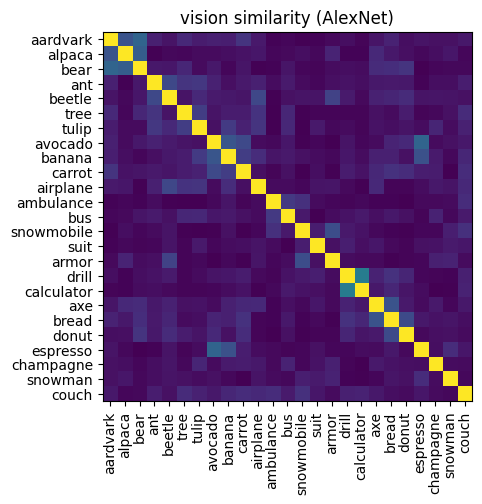

In [ ]:
# plot the representational similarity matrix among images

plt.xticks(ticks = np.arange(25), labels = categories, rotation = 90)
plt.yticks(ticks = np.arange(25), labels = categories)
plt.title('vision similarity (AlexNet)')
plt.imshow(sim(vec_vision))


We can go back to the concept of representational similarity to explore whether (unimodal) vision and language models represent concepts similarly.

<center>
  <img src="https://drive.google.com/uc?export=view&id=1pinEvLZ1SXPC75DDCxg2OPtpRZz2WcIs" width="600"/>
</center>


In [ ]:
# import language model

from minicons import cwe

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_bert_large = cwe.CWE('google-bert/bert-large-uncased', device = my_device) # from https://huggingface.co/models


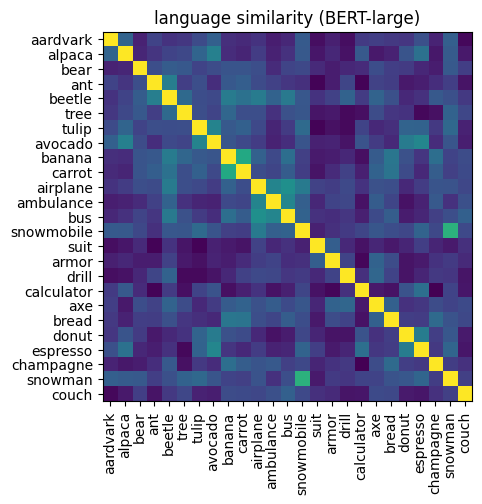

In [ ]:
# get the representational similarity matrix among sentences

c = [''.join(t) for t in list(zip(["a picture of a "] * 25, categories))] # define simple sentential context
vec_lang = model_bert_large.extract_representation(list(zip(c,categories)), layer = 10)

plt.xticks(ticks = np.arange(25), labels = categories, rotation = 90)
plt.yticks(ticks = np.arange(25), labels = categories)
plt.title('language similarity (BERT-large)')
plt.imshow(sim(vec_lang))


100%|██████████| 25/25 [00:05<00:00,  4.47it/s]


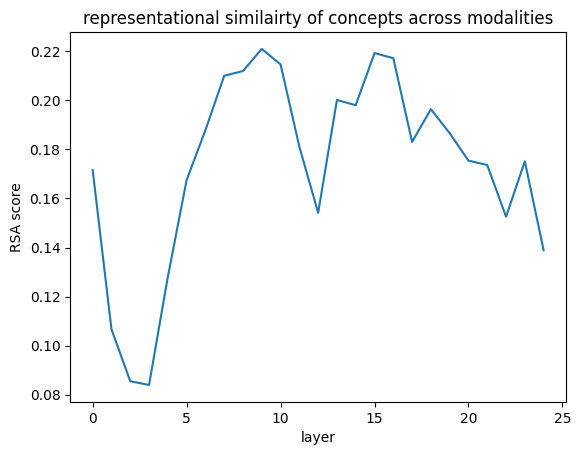

In [ ]:
# RSA between language and vision models (along models' depth)

c = [''.join(t) for t in list(zip(["a picture of a "] * 25, categories))]
rsas = torch.empty(0)

for L in tqdm(range(0,25)):
  vec_lang = model_bert_large.extract_representation(list(zip(c,categories)), layer = L) # extract language representations
  RSA_score = rsa(sim(vec_vision),sim(vec_lang)) # compute RSA

  rsas = torch.cat((rsas,RSA_score.unsqueeze(0)), dim = 0)

# plot results
plt.xlabel('layer')
plt.ylabel('RSA score')
plt.title('representational similairty of concepts across modalities')
plt.plot(rsas)


/tmp/ipython-input-141-3639129580.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


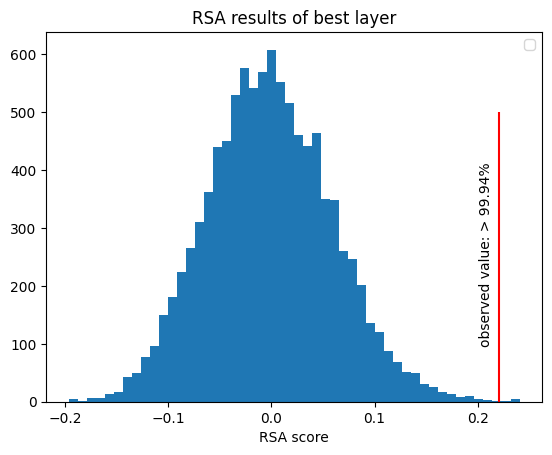

In [ ]:
# compare RSA score with random baseline

layer_maxsim = 9
vec_lang = model_bert_large.extract_representation(list(zip(c,categories)), layer = layer_maxsim) # extract language representations
RSA_score = rsa(sim(vec_vision),sim(vec_lang)) # compute RSA

rsm_lang = sim(vec_lang)
rsm_vision = sim(vec_vision)
rsa_random = []
n_perms = 10000
for p in range(n_perms):
  perm = torch.randperm(rsm_lang.shape[0]) # random, results will slightly vary
  rsm_lang_perm = rsm_lang[perm][:, perm]
  rsa_random.append(rsa(rsm_vision,rsm_lang_perm))

plt.xlabel('RSA score')
plt.title('RSA results of best layer')
plt.hist(rsa_random, bins = 50)
plt.vlines(RSA_score, 0, n_perms/20, colors = 'red')
plt.text(RSA_score - 0.02, n_perms/100, 'observed value: ' +'> ' + str(sum(rsa_random < RSA_score.numpy())/n_perms*100)  + '%', rotation = 90)
plt.legend()


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.3.1)}}$ Use your own images. You can import an image from a Drive folder with `Image.open('path_to_image').convert('RGB')` (or, if already in your Colab enviroment, `Image.open('file_name).convert('RGB')`).

  If you want, you can observe how images are represented in other layers of AlexNet. You can run `model` to display its structure (the list includes the type and dimensionality of the layers). For example, you can define a new layer to be the second convolutional layer in the model with `layer = model.features[3]`, which corresponds to 'Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))'. Note that feature dimensionality is very high in early layers and one runs the risk of saturating the RAM!

### **3.2. Vision-Language Models (VLMs)**

So far, we have looked at the correspondence of deep learning models trained independently on language or vision. While many unimodal models already display a degree of representational alingmnet, *multimodal* models are *jointly trained* on both linguistic and visual input, enabling a better cross-talk.

---

We will now use the `minicons.scorer` module and the `VLMscorer` class to look at the surprisal of tokens in captions conditioned on images.

In [ ]:
# import module

from minicons import scorer

In [ ]:
# Load a vision-language model

my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_blip = scorer.VLMScorer('Salesforce/blip-image-captioning-base', device = my_device)

In [ ]:
 # extract the sequence score of image captions

img_bear = Image.open(img_path + 'bear.jpg').convert('RGB')
captions = ['this is a photo of a brown bear, a type of mammal.',
            'this is a photo of a polar bear, a type of mammal.',
            'this is a photo of a brown bear, a type of bird.',
            'this is a photo of a polar bear, a type of bird.']

model_blip.sequence_score(
  text_batch = captions, # captions to score
  image_batch = [img_bear] * len(captions) # captioned images
)

In [ ]:
# Let's do a by-token analysis of the captions

model_blip.token_score(
  text_batch = captions,
  image_batch = [img_bear] * len(captions),
  prob = True # look at probabilities
)

In [ ]:
# conditional log-probabilities

img_airplane = Image.open(img_path + 'airplane.jpg').convert('RGB')
pre = ['This is the image of an ']
post = ['apple.',
        'airplane.',
        'obstacle.',
        'aircraft.']

cond_scores = model_blip.conditional_score(prefix = pre * len(post), stimuli = post, prob = True, image = img_airplane) # P(post|pre)
list(zip([pre[0] + p for p in post], cond_scores))


###### $\color{red}{\text{exercises}}$

*   $\color{red}{\text{(e.3.2)}}$ Play with your own images 🙂
*   $\color{red}{\text{(e.3.3)}}$ Is the model able to count? Try to evaluate BLIP's counting skills using the `token_score` or `sequence_score` functions. TIP: Among the THINGSplus images, look at 'alpaca', 'banana' and 'carrot'.

In [ ]:
# @title ###### exercise 3.3 - solution

pre = 'this is a photo of '
how_many = ['one','two','three','four','five','six','seven','eight','nine','ten']

name = 'alpaca'
captions = [pre + n + ' ' + name + 's' for n in how_many]
img = Image.open(img_path + name + '.jpg').convert('RGB')
scores = model_blip.sequence_score(
  text_batch = captions,
  image_batch = [img] * len(captions))
alpacas = list(zip(how_many, scores)) # negative log-P

name = 'banana'
captions = [pre + n + ' ' + name + 's' for n in how_many]
img = Image.open(img_path + name + '.jpg').convert('RGB')
scores = model_blip.sequence_score(
  text_batch = captions,
  image_batch = [img] * len(captions))
bananas = list(zip(how_many, scores)) # negative log-P

name = 'carrot'
captions = [pre + n + ' ' + name + 's' for n in how_many]
img = Image.open(img_path + name + '.jpg').convert('RGB')
scores = model_blip.sequence_score(
  text_batch = captions,
  image_batch = [img] * len(captions))
bananas = list(zip(how_many, scores)) # negative log-P
